## Binarization of Gene Expression and Regulation Dynamics Inference

In [ ]:
# Reference: https://gitlab.com/stemcellbioengineering/iqcell
# We used the tutorial provided in IQCELL (v 1.0.0)

In [1]:
import matplotlib as plt
import pandas as pd
import os
os.getcwd()
import iqcell

HI
iqcell successfully imported


In [2]:
#input files
Data_add='/data/normalizedgene_expression.csv'
PT_address='/data/to_cancer_Lineage6_new.csv'

#Node gene list
toC_stem = {'Mlxipl', 'Tfdp2', 'Pole4', 'Tfdp1', 'Hnf4a', 'Smarcb1', 'Gtf2f1', 'Polr3a', 'Cdx1', 'Nr3c1', 'Nr2c2', 'Cebpb', 'Mthfd1', 'Myb', 'Atf1', 'Hnf4g', 'Esrra', 'Hmgb3', 'Isx'}
toC_cancer = {'Usf1', 'Ltf', 'Foxq1', 'Sp5', 'Hoxb8', 'Zfp652', 'Nfe2l3', 'Tcf4', 'Zfp444', 'Foxa3', 'Npdc1', 'Tgif1', 'Hoxb9', 'Etv3', 'Tead2', 'Hoxb7'}
Boolean_gene_list_final = list(toC_stem | toC_cancer)


In [3]:
# output files
expression_add_magic = '/data/2_magic_expression.csv'
expression_add='/data/3_expression_data_genes_selected.csv'
interaction_add='/data/4_gene_interactions.txt'
Discretized_expression='/data/5_Discretized_expression.csv'

### Imputation

In [4]:
knn_value = 10
emt_magic, _ = iqcell.expression_recovery.run_magic_and_write_data(Data_add, knn_value, expression_add_magic)

Calculating MAGIC...
  Running MAGIC on 1235 cells and 31053 genes.
  Calculating graph and diffusion operator...


/home/csng0482/.local/lib/python3.7/site-packages/magic/magic.py:426: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  "Input matrix contains unexpressed genes. "


    Calculating PCA...
    Calculated PCA in 2.01 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.24 seconds.
  Calculated graph and diffusion operator in 2.94 seconds.
  Running MAGIC with `solver='exact'` on 31053-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.44 seconds.
Calculated MAGIC in 3.58 seconds.


###  Calculating the gene-gene interaction score between all gene pairs

1235
no TFs file is provided, all genes can interact
pearson


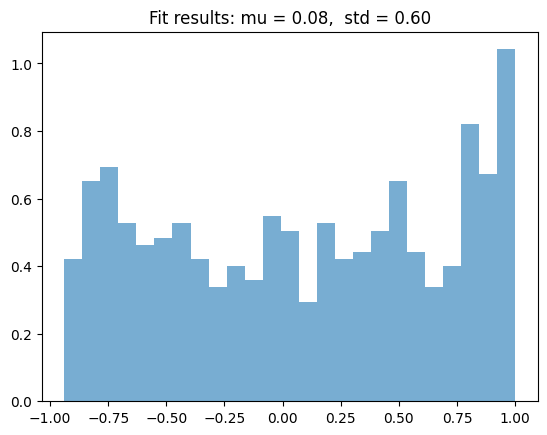

paritial pearson


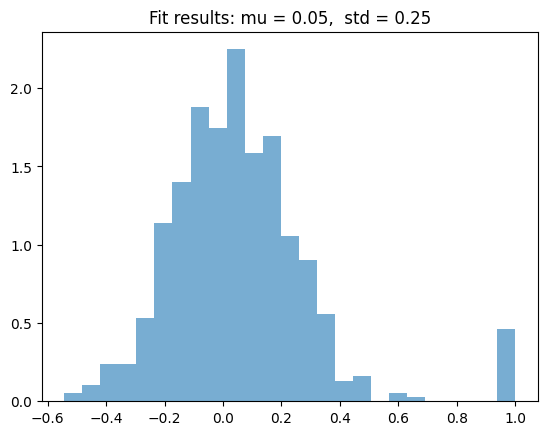

DREMI


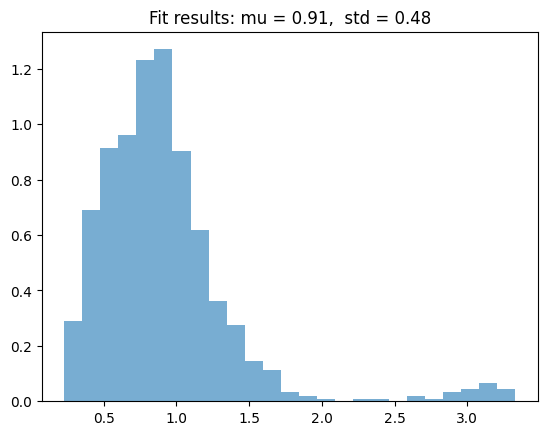

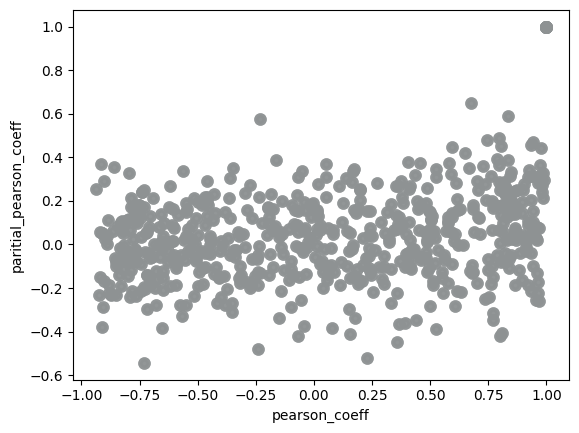

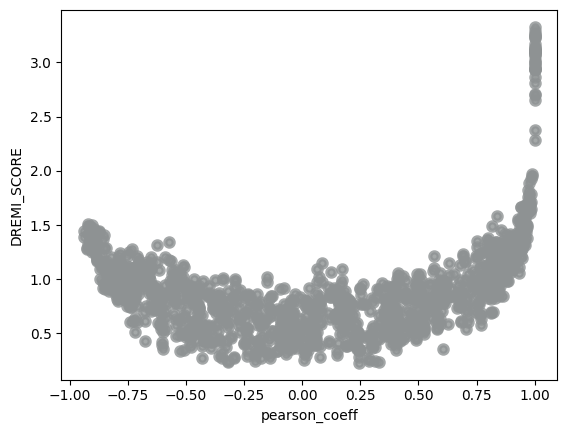

In [5]:
## this exports the expression file for the selected genes.
iqcell.gene_selection.export_selecet_genes(expression_add_magic, Boolean_gene_list_final, expression_add,plot=False)
## this calculates the gene-gene interaction score between all gene pairs.
interaction_data, pearson_coeff, paritial_pearson_coeff, DREMI_SCORE, pearson_std, Figs = iqcell.gene_interaction.calculate_the_gene_gene_interaction_in_three_ways(expression_add) 

In [6]:
# threshold to assigning a sing to the interaction: 
sign_threshold = 0.66*pearson_std
iqcell.gene_interaction.calculate_sign_and_write_data(sign_threshold, interaction_data, pearson_coeff, paritial_pearson_coeff, DREMI_SCORE, interaction_add)

### Discretization of gene expression

In [1]:
size_of_subset = len(pd.read_csv(PT_address)) # size of subset of cells to calculte threshold
df_mean, Figs_mean = iqcell.expression_discretization.mean_thresholding_method_and_plot(expression_add, PT_address, size_of_subset, plot=True)

In [2]:
size_of_subset = len(pd.read_csv(PT_address)) # size of subset of cells to calculte threshold
df_kmean, Figs_kmean = iqcell.expression_discretization.K_mean_thresholding_method_and_plot(expression_add, PT_address, size_of_subset, plot=True)

In [9]:
Threshold_method = 'K-means' # either 'K-means' or 'Mean'
iqcell.expression_discretization.export_discretized_expression(Discretized_expression, df_kmean, df_mean, Threshold_method)

### Logic inference

In [10]:
import iqcell
from iqcell import gene_hierarchy_modified as gene_h

In [11]:
number_of_cells_z3 = len(pd.read_csv(PT_address))
include_selfe_activation = False
Window_size = 100 # the window size used in calculating expression density
Percent_top = 100 # the percent of top interactions to be included !! note only signed one are included
jump_threshold_method = 'kmeans'  #'kmeans' or 'mean' or 'median' or half  value

In [12]:
file_z3 = '/home/csng0482/iqcell_package/in_out/z3files/'
monocole_all_cells_z3_add = file_z3+'z3_cellorder.txt'
z3_expression_add = file_z3+'z3_expression.txt'
z3_command_line_add = file_z3+'z3_command_line.txt'
z3_interaction_add = file_z3+'z3_interaction.txt'


# 1___generating cell order file:
monocole_cells_z3 = gene_h.generating_cell_order(monocole_all_cells_z3_add, number_of_cells_z3, PT_address)

# 2_____making the 'z3_expression.txt' file
expression_data_z3 = gene_h.generating_expression_file(Discretized_expression, z3_expression_add, monocole_cells_z3)

# 3___calculing the possible gene gene iteractions based on scores and jumps
jump_thresholds = gene_h.calculate_jump_thresholds_from_data(Window_size, expression_data_z3, monocole_cells_z3)

In [13]:
gene_jumps, _, Figs = gene_h.finding_gene_transition_points(jump_thresholds,
                                                            jump_threshold_method, Window_size,
                                                            expression_data_z3, monocole_cells_z3,
                                                            interaction_add, z3_interaction_add,
                                                            include_selfe_activation, Percent_top)

In [14]:
gene_h.export_z3_gene_interaction(z3_interaction_add, interaction_add, include_selfe_activation, gene_jumps, Percent_top)

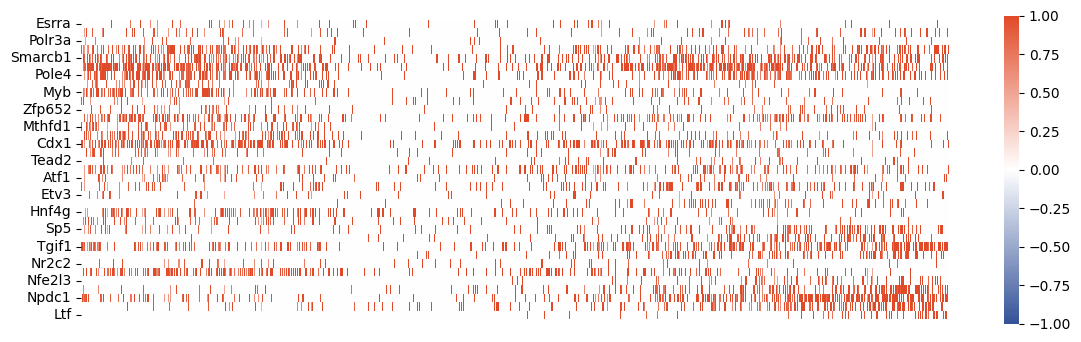

In [15]:
cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
exprresion_along_PT, Fig = gene_h.heat_map_plot_exprresion_along_PT(Data_add, PT_address,
                                                                    gene_names_=list(gene_jumps.index),
                                                                    sx=14, sy=4, cmap=cmap, vmin=-1, vmax=1)

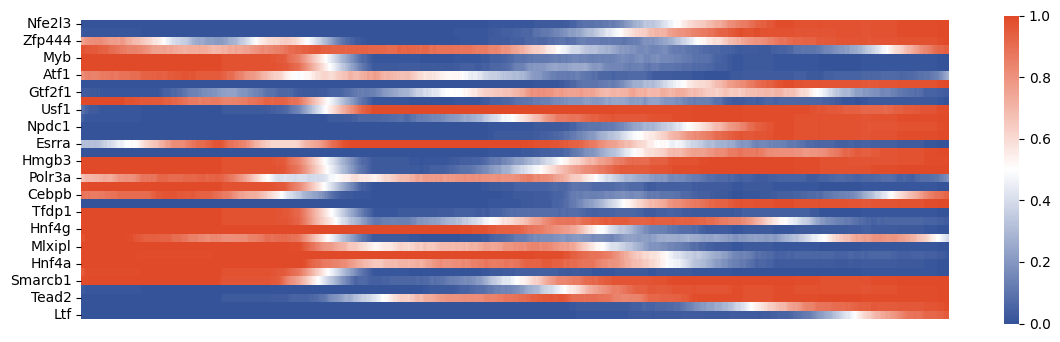

In [16]:
our_new_gene_order = Boolean_gene_list_final
cmap = plt.colors.LinearSegmentedColormap.from_list("", ["#355399",'white',"#e14a28"])
avrages_on_window, Fig = gene_h.heatmap_avraging_expression_over_window_along_PT(expression_data_add=Discretized_expression,
                                                                                  gene_names_=Boolean_gene_list_final, Window_size=100, 
                                                                                  monocole_cells_add=PT_address,
                                                                                  number_of_ssamplpes=len(pd.read_csv(PT_address)),
                                                                                  sx=14, sy=4, cmap=cmap, vmin=0, vmax=1)

In [17]:
step = 100
maxAct = 3
maxRep = 2
threshold = 1
thresholdStep = 0.05
recommended_number_of_jobs = 30 #int(mp.cpu_count())-1

In [18]:
gene_list_to_run = list(gene_jumps.loc[:,'gene'])
RL = gene_list_to_run[:]

In [19]:
iqcell.network_inference.check_z3_interactions(z3_interaction_add, gene_list_to_run, Discretized_expression, PT_address)

Zfp444 is initially on, self activation added
Polr3a is initially on, self activation added
Cebpb is initially on, self activation added
Smarcb1 is initially on, self activation added
Hmgb3 is initially on, self activation added
Pole4 is initially on, self activation added
Isx is initially on, self activation added
Myb is initially on, self activation added
Zfp652 is initially on, self activation added
Tfdp2 is initially on, self activation added
Mthfd1 is initially on, self activation added
Nr3c1 is initially on, self activation added
Cdx1 is initially on, self activation added
Tfdp1 is initially on, self activation added
Atf1 is initially on, self activation added
Etv3 is initially on, self activation added
Hnf4g is initially on, self activation added
Mlxipl is initially on, self activation added
Nr2c2 is initially on, self activation added
Hnf4a is initially on, self activation added


In [3]:
proccesses_list = iqcell.network_inference.Run_parallel_network_inference(RL, z3_expression_add, step, monocole_all_cells_z3_add, 
                                                                          maxAct, maxRep, z3_interaction_add, threshold, thresholdStep)

In [4]:
proccesses_list

In [ ]:
from iqcell import model_selection_modified as model_selection

In [ ]:
model_selection.convert_z3_to_simbool(file_z3, Boolean_gene_list_final, z3_expression_add)

file_base_z3 = file_z3
GRN_file_address = file_z3 + '8_GRN.txt'
method_to_calculate_max_score = 'DREMI' # DREMI OR pearson
model_selection.select_model_GRN(Boolean_gene_list_final, method_to_calculate_max_score, interaction_add, file_base_z3, GRN_file_address)
# Now we can visualize the candidate GRN for the data:
Network_best_GRN_z3, Fig = model_selection.convert_GRN_to_networkx(interaction_add, GRN_file_address, im_size=5)
